In [1]:
# The code was removed by Watson Studio for sharing.

# Data sources to answer what neighborhood is the most 'Minnesota Nice'?

## The hypothetical data science firm of MCG has researched the 'Minnesota Nice' business problem and determined that a variety of data needs to be gathered. In particular, geolocation data will be critical from the Foursquare API.

### A more detailed description of data requirements follows:

* Neighborhood names along with census data from the American Community Survey will be pulled from the Minnesota open data website:
 * https://www.mncompass.org/profiles/neighborhoods/minneapolis-saint-paul#!community-areas 
* Neighborhood names will be associated with central latitute/longitude coordinates using the the methods described in the StackOverflow post:
 * https://stackoverflow.com/questions/44616592/search-google-geocoding-api-by-neighborhood
   * This will use the Google API searching for a combination of Neighborhood + City and then pulling the lat-long coordinates.
   
* Foursquare data will be obtained similar to the Toronto neighborhood analysis. We plan to look at restaurants, parks, schools, and spiritual centers.
 * https://developer.foursquare.com/docs/resources/categories 
 
* Walk scores for the neighborhoods will be obtained from the 'Walk Score' API:
 * https://www.walkscore.com/professional/api.php  

## First we import a couple of useful packages

In [2]:
import pandas as pd
import numpy as np
import googlemaps
import requests
import urllib
import uszipcode

## Now I import a couple of .csv files that were pulled from the mncompass.org website. We'll combine and pull just the neighborhood names.

In [3]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

In [4]:
# The code was removed by Watson Studio for sharing.

In [94]:
body = client_a28f8de00eed48e5bb907b36c94b68c9.get_object(Bucket='minnesotanice-donotdelete-pr-m1b1j2ihuwlryd',Key='MSP Neighborhoods_2010.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body, skiprows = 1)

body = client_a28f8de00eed48e5bb907b36c94b68c9.get_object(Bucket='minnesotanice-donotdelete-pr-m1b1j2ihuwlryd',Key='MSP Neighborhoods_2013-2017.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_2 = pd.read_csv(body, skiprows = 1)

df1 = df_data_1[['geography', 'City', 'Average household size - count (2010 Census)', 'Total population - Total - count (2010 Census)', 'Population under age 18 - share (2010 Census)']]
df1 = df1.rename(index=str, columns={'geography': "geography", "City": "City", 'Average household size - count (2010 Census)': "household_size", 'Total population - Total - count (2010 Census)': "total_population", 'Population under age 18 - share (2010 Census)' : 'share_population_under18'})
df2 = df_data_2[['geography', 'City', 'Average household size - count (2013-2017 ACS)', 'Total population - Total population - count (2013-2017 ACS)', 'Population under age 18 - share (2010 Census)']]
df2 = df2.rename(index=str, columns={'geography': "geography", "City": "City", 'Average household size - count (2013-2017 ACS)': "household_size", 'Total population - Total population - count (2013-2017 ACS)': "total_population", 'Population under age 18 - share (2010 Census)' : 'share_population_under18'})

TwinCityNeighborhoods = df1.append(df2)

### Just quick sanity check on the import

In [95]:
TwinCityNeighborhoods.head()

,geography,City,household_size,total_population,share_population_under18
0,Mid-City Industrial,Minneapolis,1.480278,213.0,0.031250
1,University of Minnesota,Minneapolis,3.722899,5421.0,0.384615
2,Northeast Park,Minneapolis,2.390534,672.0,0.288684
3,Beltrami,Minneapolis,2.886937,1248.0,0.364183
4,Downtown East,Minneapolis,1.629117,1254.0,0.110879


In [96]:
TwinCityNeighborhoods.shape

(113, 5)

### We know there are 102 neighborhoods from the website listing so let's drop any duplicates.

In [97]:
TwinCityNeighborhoods = TwinCityNeighborhoods.drop_duplicates().dropna()

### Now since we need lat-longs, we'll make a list of the neighborhoods we want to search for on the google API.

In [98]:
TwinCityNeighborhoods['neighborhood'] = TwinCityNeighborhoods.geography + ", " + TwinCityNeighborhoods.City

In [99]:
TwinCityNeighborhoods.head()

,geography,City,household_size,total_population,share_population_under18,neighborhood
0,Mid-City Industrial,Minneapolis,1.480278,213.0,0.031250,"Mid-City Industrial, Minneapolis"
1,University of Minnesota,Minneapolis,3.722899,5421.0,0.384615,"University of Minnesota, Minneapolis"
2,Northeast Park,Minneapolis,2.390534,672.0,0.288684,"Northeast Park, Minneapolis"
3,Beltrami,Minneapolis,2.886937,1248.0,0.364183,"Beltrami, Minneapolis"
4,Downtown East,Minneapolis,1.629117,1254.0,0.110879,"Downtown East, Minneapolis"


In [100]:
# The code was removed by Watson Studio for sharing.

In [101]:
def geocode_address_lat(loc):
    geocode_result = gmaps.geocode(loc)
    lat = geocode_result[0]["geometry"]["location"]["lat"]
    return(lat)
    
def geocode_address_lon(loc):
    geocode_result = gmaps.geocode(loc)
    lon = geocode_result[0]["geometry"]["location"]["lng"]
    return(lon)


In [102]:
TwinCityNeighborhoods['latitude'] = TwinCityNeighborhoods['neighborhood'].apply(geocode_address_lat);
TwinCityNeighborhoods['longitude'] = TwinCityNeighborhoods['neighborhood'].apply(geocode_address_lon);


In [103]:
TwinCityNeighborhoods.head()

,geography,City,household_size,total_population,share_population_under18,neighborhood,latitude,longitude
0,Mid-City Industrial,Minneapolis,1.480278,213.0,0.031250,"Mid-City Industrial, Minneapolis",44.998862,-93.217771
1,University of Minnesota,Minneapolis,3.722899,5421.0,0.384615,"University of Minnesota, Minneapolis",44.973990,-93.227728
2,Northeast Park,Minneapolis,2.390534,672.0,0.288684,"Northeast Park, Minneapolis",45.003120,-93.241263
3,Beltrami,Minneapolis,2.886937,1248.0,0.364183,"Beltrami, Minneapolis",44.994943,-93.241600
4,Downtown East,Minneapolis,1.629117,1254.0,0.110879,"Downtown East, Minneapolis",44.975911,-93.254587


## To use the walkscore API, we also need an address to associate with the lat-long. We'll now do the reverse geocode to associate a human recognizable address.

In [104]:
# The code was removed by Watson Studio for sharing.

In [105]:
def geocode_address(loc):
    geocode_result = gmaps.geocode(loc)
    address = geocode_result[0]['formatted_address']
    return(address)

In [106]:
TwinCityNeighborhoods['lat-lon'] = TwinCityNeighborhoods.latitude.map(str) + "," + TwinCityNeighborhoods.longitude.map(str);
TwinCityNeighborhoods['address'] = TwinCityNeighborhoods['lat-lon'].apply(geocode_address);

In [107]:
TwinCityNeighborhoods.head()

,geography,City,household_size,total_population,share_population_under18,neighborhood,latitude,longitude,lat-lon,address
0,Mid-City Industrial,Minneapolis,1.480278,213.0,0.031250,"Mid-City Industrial, Minneapolis",44.998862,-93.217771,"44.9988622,-93.2177712","Broadway St NE & Hoover St, Minneapolis, MN 55..."
1,University of Minnesota,Minneapolis,3.722899,5421.0,0.384615,"University of Minnesota, Minneapolis",44.973990,-93.227728,"44.97399,-93.2277285","Oak St SE & Washington Ave SE, Minneapolis, MN..."
2,Northeast Park,Minneapolis,2.390534,672.0,0.288684,"Northeast Park, Minneapolis",45.003120,-93.241263,"45.0031203,-93.2412634","1653 Fillmore St NE, Minneapolis, MN 55413, USA"
3,Beltrami,Minneapolis,2.886937,1248.0,0.364183,"Beltrami, Minneapolis",44.994943,-93.241600,"44.994943,-93.2415998","453 Fillmore St NE, Minneapolis, MN 55413, USA"
4,Downtown East,Minneapolis,1.629117,1254.0,0.110879,"Downtown East, Minneapolis",44.975911,-93.254587,"44.9759107,-93.25458719999999","1001 S Washington Ave, Minneapolis, MN 55415, USA"


In [108]:
def walkscore(address, latitude, longitude, walk_key = walk_key):
    walk_base_url = 'http://api.walkscore.com/score'
    w_url = walk_base_url + '?' + urllib.parse.urlencode({
        'format': 'json',
        'address': str(address),
        'lat': str(latitude),
        'lon': str(longitude),
        'wsapikey': walk_key,
        'transit': 1
    })
    results=requests.get(w_url).json()
    return(results['walkscore'])

In [109]:
TwinCityNeighborhoods['walkscore'] = TwinCityNeighborhoods.apply(lambda x: walkscore(x.address, x.latitude, x.longitude), axis = 1);

In [110]:
TwinCityNeighborhoods.head()

,geography,City,household_size,total_population,share_population_under18,neighborhood,latitude,longitude,lat-lon,address,walkscore
0,Mid-City Industrial,Minneapolis,1.480278,213.0,0.031250,"Mid-City Industrial, Minneapolis",44.998862,-93.217771,"44.9988622,-93.2177712","Broadway St NE & Hoover St, Minneapolis, MN 55...",34
1,University of Minnesota,Minneapolis,3.722899,5421.0,0.384615,"University of Minnesota, Minneapolis",44.973990,-93.227728,"44.97399,-93.2277285","Oak St SE & Washington Ave SE, Minneapolis, MN...",77
2,Northeast Park,Minneapolis,2.390534,672.0,0.288684,"Northeast Park, Minneapolis",45.003120,-93.241263,"45.0031203,-93.2412634","1653 Fillmore St NE, Minneapolis, MN 55413, USA",62
3,Beltrami,Minneapolis,2.886937,1248.0,0.364183,"Beltrami, Minneapolis",44.994943,-93.241600,"44.994943,-93.2415998","453 Fillmore St NE, Minneapolis, MN 55413, USA",59
4,Downtown East,Minneapolis,1.629117,1254.0,0.110879,"Downtown East, Minneapolis",44.975911,-93.254587,"44.9759107,-93.25458719999999","1001 S Washington Ave, Minneapolis, MN 55415, USA",90


## Now we grab the median homevalue and median household income for each neighborhood, however it will only be as unique as the zipcode it resides in.

In [111]:
from uszipcode import Zipcode
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True)

def zip_search_income(latitude, longitude, radius = 30, returns = 1):
    result = search.by_coordinates(latitude, longitude, radius = radius, returns = returns)
    median_household_income = result[0].median_household_income
    return(median_household_income)

def zip_search_homeval(latitude, longitude, radius = 30, returns = 1):
    result = search.by_coordinates(latitude, longitude, radius = radius, returns = returns)
    median_home_value = result[0].median_home_value
    return(median_home_value)

In [112]:
TwinCityNeighborhoods['median_household_income'] = TwinCityNeighborhoods.apply(lambda x: zip_search_income(x.latitude, x.longitude), axis = 1);
TwinCityNeighborhoods['median_home_value'] = TwinCityNeighborhoods.apply(lambda x: zip_search_homeval(x.latitude, x.longitude), axis = 1);

## Looks like there are 3-5 neighborhoods that return NaN values for the median household income and home value. Instead of dropping those neighborhoods, we'll impute the NaN with the mean for that column.

In [119]:
TwinCityNeighborhoods.fillna(TwinCityNeighborhoods.median(), inplace = True)

In [120]:
TwinCityNeighborhoods.head()

,geography,City,household_size,total_population,share_population_under18,neighborhood,latitude,longitude,lat-lon,address,walkscore,median_household_income,median_home_value
0,Mid-City Industrial,Minneapolis,1.480278,213.0,0.031250,"Mid-City Industrial, Minneapolis",44.998862,-93.217771,"44.9988622,-93.2177712","Broadway St NE & Hoover St, Minneapolis, MN 55...",34,45518.000000,195800.000000
1,University of Minnesota,Minneapolis,3.722899,5421.0,0.384615,"University of Minnesota, Minneapolis",44.973990,-93.227728,"44.97399,-93.2277285","Oak St SE & Washington Ave SE, Minneapolis, MN...",77,53316.989899,214517.525773
2,Northeast Park,Minneapolis,2.390534,672.0,0.288684,"Northeast Park, Minneapolis",45.003120,-93.241263,"45.0031203,-93.2412634","1653 Fillmore St NE, Minneapolis, MN 55413, USA",62,45518.000000,195800.000000
3,Beltrami,Minneapolis,2.886937,1248.0,0.364183,"Beltrami, Minneapolis",44.994943,-93.241600,"44.994943,-93.2415998","453 Fillmore St NE, Minneapolis, MN 55413, USA",59,45518.000000,195800.000000
4,Downtown East,Minneapolis,1.629117,1254.0,0.110879,"Downtown East, Minneapolis",44.975911,-93.254587,"44.9759107,-93.25458719999999","1001 S Washington Ave, Minneapolis, MN 55415, USA",90,52736.000000,241000.000000


## Now let's export this .csv so we have an intermediate result in case we have to restart the kernel. Don't want to re-hit the GoogleAPI and run into paying. 

In [130]:
# Save dataframe as csv file to storage
project.save_data(data=TwinCityNeighborhoods.to_csv(index=False),file_name='TwinCityNeighborhoods.csv',overwrite=True)


{'file_name': 'TwinCityNeighborhoods.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'minnesotanice-donotdelete-pr-m1b1j2ihuwlryd',
 'asset_id': '12a09502-9234-4208-9577-6d8e26cdfa27'}

## Read the Twin City Neighborhoods dataframe back in...

In [5]:
body = client_a28f8de00eed48e5bb907b36c94b68c9.get_object(Bucket='minnesotanice-donotdelete-pr-m1b1j2ihuwlryd',Key='TwinCityNeighborhoods.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

TwinCityNeighborhoodsDF = pd.read_csv(body)
TwinCityNeighborhoodsDF.head()


,geography,City,household_size,total_population,share_population_under18,neighborhood,latitude,longitude,lat-lon,address,walkscore,median_household_income,median_home_value
0,Mid-City Industrial,Minneapolis,1.480278,213.0,0.031250,"Mid-City Industrial, Minneapolis",44.998862,-93.217771,"44.9988622,-93.2177712","Broadway St NE & Hoover St, Minneapolis, MN 55...",34,45518.000000,195800.000000
1,University of Minnesota,Minneapolis,3.722899,5421.0,0.384615,"University of Minnesota, Minneapolis",44.973990,-93.227728,"44.97399,-93.2277285","Oak St SE & Washington Ave SE, Minneapolis, MN...",77,53316.989899,214517.525773
2,Northeast Park,Minneapolis,2.390534,672.0,0.288684,"Northeast Park, Minneapolis",45.003120,-93.241263,"45.0031203,-93.2412634","1653 Fillmore St NE, Minneapolis, MN 55413, USA",62,45518.000000,195800.000000
3,Beltrami,Minneapolis,2.886937,1248.0,0.364183,"Beltrami, Minneapolis",44.994943,-93.241600,"44.994943,-93.2415998","453 Fillmore St NE, Minneapolis, MN 55413, USA",59,45518.000000,195800.000000
4,Downtown East,Minneapolis,1.629117,1254.0,0.110879,"Downtown East, Minneapolis",44.975911,-93.254587,"44.9759107,-93.25458719999999","1001 S Washington Ave, Minneapolis, MN 55415, USA",90,52736.000000,241000.000000


In [43]:
TwinCityNeighborhoodsDF

,geography,City,household_size,total_population,share_population_under18,neighborhood,latitude,longitude,lat-lon,address,walkscore,median_household_income,median_home_value
0,Mid-City Industrial,Minneapolis,1.480278,213.000000,0.031250,"Mid-City Industrial, Minneapolis",44.998862,-93.217771,"44.9988622,-93.2177712","Broadway St NE & Hoover St, Minneapolis, MN 55...",34,45518.000000,195800.000000
1,University of Minnesota,Minneapolis,3.722899,5421.000000,0.384615,"University of Minnesota, Minneapolis",44.973990,-93.227728,"44.97399,-93.2277285","Oak St SE & Washington Ave SE, Minneapolis, MN...",77,53316.989899,214517.525773
2,Northeast Park,Minneapolis,2.390534,672.000000,0.288684,"Northeast Park, Minneapolis",45.003120,-93.241263,"45.0031203,-93.2412634","1653 Fillmore St NE, Minneapolis, MN 55413, USA",62,45518.000000,195800.000000
3,Beltrami,Minneapolis,2.886937,1248.000000,0.364183,"Beltrami, Minneapolis",44.994943,-93.241600,"44.994943,-93.2415998","453 Fillmore St NE, Minneapolis, MN 55413, USA",59,45518.000000,195800.000000
4,Downtown East,Minneapolis,1.629117,1254.000000,0.110879,"Downtown East, Minneapolis",44.975911,-93.254587,"44.9759107,-93.25458719999999","1001 S Washington Ave, Minneapolis, MN 55415, USA",90,52736.000000,241000.000000
5,Kenwood,Minneapolis,2.548542,1468.000000,0.295455,"Kenwood, Minneapolis",44.959105,-93.312002,"44.9591051,-93.3120017","2400 Russell Ave S, Minneapolis, MN 55405, USA",33,48913.000000,316200.000000
6,Sumner-Glenwood,Minneapolis,2.360400,1475.000000,0.503704,"Sumner-Glenwood, Minneapolis",44.984204,-93.290894,"44.98420360000001,-93.29089429999999","505 6th Ave N, Minneapolis, MN 55405, USA",74,36849.000000,242900.000000
7,Bottineau,Minneapolis,2.562074,1656.000000,0.416952,"Bottineau, Minneapolis",45.008185,-93.268369,"45.0081846,-93.2683692","1919 Grand St NE, Minneapolis, MN 55418, USA",66,84297.000000,257800.000000
8,Marshall Terrace,Minneapolis,2.108779,1381.000000,0.331002,"Marshall Terrace, Minneapolis",45.021019,-93.268571,"45.0210186,-93.268571","2911 29th Ave NE, Minneapolis, MN 55418, USA",30,55486.000000,189000.000000
9,Columbia Park,Minneapolis,2.371912,1563.000000,0.269127,"Columbia Park, Minneapolis",45.025961,-93.259020,"45.0259608,-93.2590201","446 St Anthony Pkwy, Minneapolis, MN 55418, USA",18,55486.000000,189000.000000


## Now I'm just going to start dropping in the code from the Toronto Analysis

In [6]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

In [14]:
address = 'Minneapolis'

geolocator = Nominatim(user_agent="msp_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Minneapolis - St. Paul are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Minneapolis - St. Paul are 44.9772995, -93.2654692.


In [17]:
# create map of the Twin Cities using latitude and longitude values
map_msp = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(TwinCityNeighborhoodsDF['latitude'], TwinCityNeighborhoodsDF['longitude'], TwinCityNeighborhoodsDF['neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_msp)  
    
map_msp

In [19]:
# The code was removed by Watson Studio for sharing.

Your credentails:
CLIENT_ID: EI5AMFPD2ID24WLV3HXN1BR0HUIZFQDKVKRO4IBMTIKXH2X1
CLIENT_SECRET:YP0CXNHM05LV3FQLSTHHNHLI5YXSQA2TAMXKK2DXOXA5DNLW


In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:
MSPVenues = getNearbyVenues(names=TwinCityNeighborhoodsDF['neighborhood'],
                                   latitudes=TwinCityNeighborhoodsDF['latitude'],
                                   longitudes=TwinCityNeighborhoodsDF['longitude']
                                  )

Mid-City Industrial, Minneapolis
University of Minnesota, Minneapolis
Northeast Park, Minneapolis
Beltrami, Minneapolis
Downtown East, Minneapolis
Kenwood, Minneapolis
Sumner-Glenwood, Minneapolis
Bottineau, Minneapolis
Marshall Terrace, Minneapolis
Columbia Park, Minneapolis
Page, Minneapolis
Nicollet Island-East Bank, Minneapolis
Regina, Minneapolis
Bryant, Minneapolis
McKinley, Minneapolis
Logan Park, Minneapolis
Field, Minneapolis
St. Anthony East, Minneapolis
Shingle Creek, Minneapolis
St. Anthony West, Minneapolis
East Phillips, Minneapolis
Cleveland, Minneapolis
West Calhoun, Minneapolis
Harrison, Minneapolis
Bryn-Mawr, Minneapolis
ECCO, Minneapolis
Morris Park, Minneapolis
Hale, Minneapolis
Sheridan, Minneapolis
Ericsson, Minneapolis
Bancroft, Minneapolis
Keewaydin, Minneapolis
Hawthorne, Minneapolis
Midtown Phillips, Minneapolis
Corcoran, Minneapolis
Kenny, Minneapolis
Cooper, Minneapolis
East Harriet, Minneapolis
Cedar-Isles-Dean, Minneapolis
Lind-Bohanon, Minneapolis
Holland

In [26]:
print(MSPVenues.shape)
MSPVenues.head()

(1632, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Mid-City Industrial, Minneapolis",44.998862,-93.217771,Costco Business Center,45.000867,-93.216233,Warehouse Store
1,"Mid-City Industrial, Minneapolis",44.998862,-93.217771,James E. Casey Institute of Higher Learning,44.997521,-93.214788,Planetarium
2,"Mid-City Industrial, Minneapolis",44.998862,-93.217771,Gastrotruck,44.998147,-93.221344,Food Truck
3,"Mid-City Industrial, Minneapolis",44.998862,-93.217771,Fetch Delivers,44.998250,-93.221769,Pet Store
4,"Mid-City Industrial, Minneapolis",44.998862,-93.217771,Smack Shack,45.002637,-93.217772,Food Truck


In [27]:
MSPVenues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Armatage, Minneapolis",5,5,5,5,5,5
"Audubon Park, Minneapolis",16,16,16,16,16,16
"Bancroft, Minneapolis",3,3,3,3,3,3
"Battle Creek-Highwood, St. Paul",1,1,1,1,1,1
"Beltrami, Minneapolis",10,10,10,10,10,10
"Bottineau, Minneapolis",15,15,15,15,15,15
"Bryant, Minneapolis",9,9,9,9,9,9
"Bryn-Mawr, Minneapolis",9,9,9,9,9,9
"Cedar Riverside, Minneapolis",26,26,26,26,26,26


In [28]:
print('There are {} uniques categories.'.format(len(MSPVenues['Venue Category'].unique())))

There are 277 uniques categories.


In [29]:
# one hot encoding
MSP_onehot = pd.get_dummies(MSPVenues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
MSP_onehot['Neighborhood'] = MSPVenues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [MSP_onehot.columns[-1]] + list(MSP_onehot.columns[:-1])
MSP_onehot = MSP_onehot[fixed_columns]

MSP_onehot.head()



,Neighborhood,ATM,Accessories Store,Acupuncturist,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,...,Waterfall,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,"Mid-City Industrial, Minneapolis",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Mid-City Industrial, Minneapolis",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Mid-City Industrial, Minneapolis",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Mid-City Industrial, Minneapolis",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Mid-City Industrial, Minneapolis",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
MSP_onehot.shape

(1632, 278)

In [31]:
MSP_grouped = MSP_onehot.groupby('Neighborhood').mean().reset_index()
MSP_grouped

,Neighborhood,ATM,Accessories Store,Acupuncturist,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,...,Waterfall,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,"Armatage, Minneapolis",0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Audubon Park, Minneapolis",0.000000,0.000000,0.00000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,...,0.0,0.00,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Bancroft, Minneapolis",0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,"Battle Creek-Highwood, St. Paul",0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,"Beltrami, Minneapolis",0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
5,"Bottineau, Minneapolis",0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,...,0.0,0.00,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
6,"Bryant, Minneapolis",0.000000,0.000000,0.00000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,...,0.0,0.00,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
7,"Bryn-Mawr, Minneapolis",0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,...,0.0,0.00,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
8,"Cedar Riverside, Minneapolis",0.000000,0.000000,0.00000,0.000000,0.038462,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
9,"Cedar-Isles-Dean, Minneapolis",0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.00,0.0,0.00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000


In [32]:
MSP_grouped.shape

(102, 278)

In [34]:
num_top_venues = 5

for neighborhood in MSP_grouped['Neighborhood']:
    print("----"+neighborhood+"----")
    temp = MSP_grouped[MSP_grouped['Neighborhood'] == neighborhood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Armatage, Minneapolis----
               venue  freq
0              Trail   0.2
1         Skate Park   0.2
2        Pizza Place   0.2
3  Convenience Store   0.2
4               Park   0.2


----Audubon Park, Minneapolis----
                 venue  freq
0    Convenience Store  0.12
1       Cosmetics Shop  0.12
2             Pharmacy  0.12
3   Chinese Restaurant  0.06
4  Arts & Crafts Store  0.06


----Bancroft, Minneapolis----
                venue  freq
0      Discount Store  0.33
1  Chinese Restaurant  0.33
2         Candy Store  0.33
3    Pedestrian Plaza  0.00
4           Piano Bar  0.00


----Battle Creek-Highwood, St. Paul----
                   venue  freq
0     Recycling Facility   1.0
1                    ATM   0.0
2  Outdoors & Recreation   0.0
3               Pharmacy   0.0
4              Pet Store   0.0


----Beltrami, Minneapolis----
            venue  freq
0         Gay Bar   0.1
1  Cosmetics Shop   0.1
2        Platform   0.1
3      Hot Spring   0.1
4      Playground 

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = MSP_grouped['Neighborhood']

for ind in np.arange(MSP_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(MSP_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Armatage, Minneapolis",Skate Park,Park,Convenience Store,Pizza Place,Trail,Zoo Exhibit,Flower Shop,Fish Market,Fishing Spot,Flea Market
1,"Audubon Park, Minneapolis",Cosmetics Shop,Pharmacy,Convenience Store,Bakery,Coffee Shop,Flea Market,Chinese Restaurant,Pizza Place,Thrift / Vintage Store,Arts & Crafts Store
2,"Bancroft, Minneapolis",Discount Store,Chinese Restaurant,Candy Store,Food & Drink Shop,Flea Market,Flower Shop,Fondue Restaurant,Food,Food Court,Fish Market
3,"Battle Creek-Highwood, St. Paul",Recycling Facility,Food & Drink Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Fondue Restaurant,Food,Food Court,Garden
4,"Beltrami, Minneapolis",Playground,Cosmetics Shop,Gift Shop,Café,Gay Bar,Platform,Hot Spring,Clothing Store,Brewery,Bus Station


## This cell creates the dataframe for K-means cluster analysis

In [ ]:
MSP_grouped_clustering1 = MSP_grouped.join(TwinCityNeighborhoodsDF.set_index('neighborhood'), on = 'Neighborhood')

MSP_grouped_clustering2 = MSP_grouped_clustering1.drop(['Neighborhood', 'latitude', 'longitude', 'lat-lon', 'address', 'geography', 'City'], 1)


## Here we want to analyze what the 'best' number of clusters to use in terms of describing the neighborhoods in Minneapolis - St. Paul

In [76]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(MSP_grouped_clustering2)
    Sum_of_squared_distances.append(km.inertia_)

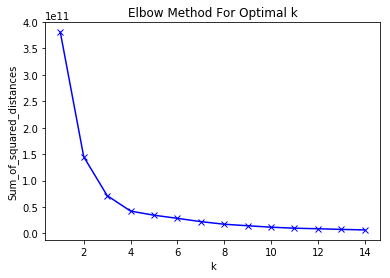

In [80]:
from matplotlib import pyplot as plt

plot = plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')

plot

In [82]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(MSP_grouped_clustering2)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([2, 3, 3, 1, 3, 6, 0, 7, 1, 2], dtype=int32)

In [83]:
# neighborhoods_venues_sorted.drop('Cluster Labels', 1, inplace = True);

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

MSP_merged = TwinCityNeighborhoodsDF

# merge MSP_grouped with MSP_data to add latitude/longitude for each neighborhood
MSP_merged = MSP_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='neighborhood')

MSP_merged.head() # check the last columns!

,geography,City,household_size,total_population,share_population_under18,neighborhood,latitude,longitude,lat-lon,address,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Mid-City Industrial,Minneapolis,1.480278,213.0,0.031250,"Mid-City Industrial, Minneapolis",44.998862,-93.217771,"44.9988622,-93.2177712","Broadway St NE & Hoover St, Minneapolis, MN 55...",...,Food Truck,Planetarium,Scenic Lookout,Pet Store,Warehouse Store,Zoo Exhibit,Flower Shop,Fish & Chips Shop,Fish Market,Fishing Spot
1,University of Minnesota,Minneapolis,3.722899,5421.0,0.384615,"University of Minnesota, Minneapolis",44.973990,-93.227728,"44.97399,-93.2277285","Oak St SE & Washington Ave SE, Minneapolis, MN...",...,Pizza Place,Coffee Shop,Chinese Restaurant,Pharmacy,College Rec Center,Korean Restaurant,Mexican Restaurant,Asian Restaurant,Fried Chicken Joint,Tanning Salon
2,Northeast Park,Minneapolis,2.390534,672.0,0.288684,"Northeast Park, Minneapolis",45.003120,-93.241263,"45.0031203,-93.2412634","1653 Fillmore St NE, Minneapolis, MN 55413, USA",...,Brewery,Theater,Bus Station,Chinese Restaurant,Park,Food Truck,Baseball Field,Art Gallery,Spa,Sporting Goods Shop
3,Beltrami,Minneapolis,2.886937,1248.0,0.364183,"Beltrami, Minneapolis",44.994943,-93.241600,"44.994943,-93.2415998","453 Fillmore St NE, Minneapolis, MN 55413, USA",...,Playground,Cosmetics Shop,Gift Shop,Café,Gay Bar,Platform,Hot Spring,Clothing Store,Brewery,Bus Station
4,Downtown East,Minneapolis,1.629117,1254.0,0.110879,"Downtown East, Minneapolis",44.975911,-93.254587,"44.9759107,-93.25458719999999","1001 S Washington Ave, Minneapolis, MN 55415, USA",...,Theater,Japanese Restaurant,Bar,Hotel,American Restaurant,Office,Beer Store,Brewery,Sports Club,Sporting Goods Shop


In [85]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(MSP_merged['latitude'], MSP_merged['longitude'], MSP_merged['neighborhood'], MSP_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## OK, let's export the merged dataframe with cluster labels as a csv for further analyses.

In [86]:
# Save dataframe as csv file to storage
project.save_data(data=MSP_merged.to_csv(index=False),file_name='MSP_Analyzed.csv',overwrite=True)


{'file_name': 'MSP_Analyzed.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'minnesotanice-donotdelete-pr-m1b1j2ihuwlryd',
 'asset_id': 'f0f5c6ae-b607-4dd2-9864-36e5fa0b8706'}

## Reading it back in now!

In [87]:
body = client_a28f8de00eed48e5bb907b36c94b68c9.get_object(Bucket='minnesotanice-donotdelete-pr-m1b1j2ihuwlryd',Key='MSP_Analyzed.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

MSP_Analyzed_DF = pd.read_csv(body)
MSP_Analyzed_DF.head()

,geography,City,household_size,total_population,share_population_under18,neighborhood,latitude,longitude,lat-lon,address,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Mid-City Industrial,Minneapolis,1.480278,213.0,0.031250,"Mid-City Industrial, Minneapolis",44.998862,-93.217771,"44.9988622,-93.2177712","Broadway St NE & Hoover St, Minneapolis, MN 55...",...,Food Truck,Planetarium,Scenic Lookout,Pet Store,Warehouse Store,Zoo Exhibit,Flower Shop,Fish & Chips Shop,Fish Market,Fishing Spot
1,University of Minnesota,Minneapolis,3.722899,5421.0,0.384615,"University of Minnesota, Minneapolis",44.973990,-93.227728,"44.97399,-93.2277285","Oak St SE & Washington Ave SE, Minneapolis, MN...",...,Pizza Place,Coffee Shop,Chinese Restaurant,Pharmacy,College Rec Center,Korean Restaurant,Mexican Restaurant,Asian Restaurant,Fried Chicken Joint,Tanning Salon
2,Northeast Park,Minneapolis,2.390534,672.0,0.288684,"Northeast Park, Minneapolis",45.003120,-93.241263,"45.0031203,-93.2412634","1653 Fillmore St NE, Minneapolis, MN 55413, USA",...,Brewery,Theater,Bus Station,Chinese Restaurant,Park,Food Truck,Baseball Field,Art Gallery,Spa,Sporting Goods Shop
3,Beltrami,Minneapolis,2.886937,1248.0,0.364183,"Beltrami, Minneapolis",44.994943,-93.241600,"44.994943,-93.2415998","453 Fillmore St NE, Minneapolis, MN 55413, USA",...,Playground,Cosmetics Shop,Gift Shop,Café,Gay Bar,Platform,Hot Spring,Clothing Store,Brewery,Bus Station
4,Downtown East,Minneapolis,1.629117,1254.0,0.110879,"Downtown East, Minneapolis",44.975911,-93.254587,"44.9759107,-93.25458719999999","1001 S Washington Ave, Minneapolis, MN 55415, USA",...,Theater,Japanese Restaurant,Bar,Hotel,American Restaurant,Office,Beer Store,Brewery,Sports Club,Sporting Goods Shop
